### Import modules

In [138]:
%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

if sys.version_info[0] ==3:
    import pickle
else:
    import cPickle as pickle
import errno

#import SRW core functions
from wpg.srwlib import srwl, srwl_opt_setup_CRL, SRWLOptD, SRWLOptA, SRWLOptC, SRWLOptT

#import SRW auxiliary functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh, plot_1d, plot_2d

from wpg.wpg_uti_wf import propagate_wavefront
from wpg.wpg_uti_oe import show_transmission

#from wpg.useful_code.wfrutils import propagate_wavefront

#Import base wavefront class
from wpg import Wavefront

#Import base beamline class and OE wrappers
from wpg.beamline import Beamline
from wpg.optical_elements import Empty, Use_PP
from wpg.optical_elements import         Drift,Aperture,    Lens,Mirror_elliptical,WF_dist,calculateOPD

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy

plt.ion()

### Define auxiliary functions

In [140]:
def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011

    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * np.sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

def _save_object(obj, file_name):
    """
    Save any python object to file.

    :param: obj : - python objest to be saved
    :param: file_name : - output file, wil be overwrite if exists
    """
    with open(file_name,'wb') as f:
        pickle.dump(obj, f)

def _load_object(file_name):
    """
    Save any python object to file.

    :param: file_name : - output file, wil be overwrite if exists
    :return: obj : - loaded pthon object
    """
    res = None
    with open(file_name,'rb') as f:
        res = pickle.load(f)

    return res

def mkdir_p(path):
    """
    Create directory with subfolders (like Linux mkdir -p)

    :param path: Path to be created
    """
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise


### Defining initial wavefront and writing electric field data to h5-file

*****defining initial wavefront and writing electric field data to h5-file...
sigX, waist_fwhm [um], far field theta_fwhms [urad]: 11.499788231945866, 27.079931842197144,2.9970290603902483
save hdf5: g6_742kev.h5
done
FWHMx [mm]: 0.70276295188322
FWHMy [mm]: 0.70276295188322
Coordinates of center, [mm]: -0.0005236683695106648 -0.0005236683695106648
stepX, stepY [um]: 1.0473367390211923 1.0473367390211923 

Total power (integrated over full range): 54.4336 [GW]
Peak power calculated using FWHM:         54.4026 [GW]
Max irradiance: 96.8183 [GW/mm^2]
R-space
FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist: 0.70276295188322, 2.9904806463115747


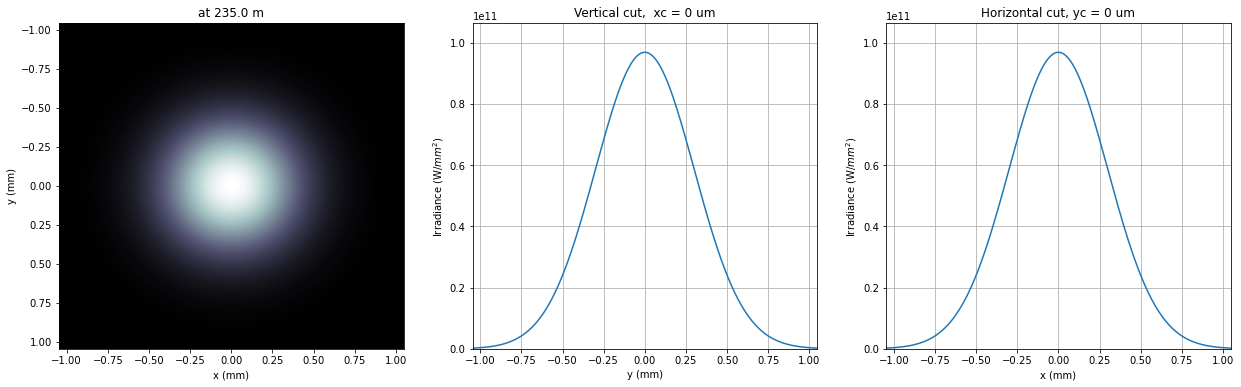

In [175]:
print('*****defining initial wavefront and writing electric field data to h5-file...')
strDataFolderName = 'WPG_output' # output data sub-folder name
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

d2crl1_sase1 = 235.0 # Distance to CRL1 on SASE1 [m]
d2crl1_sase2 = 235.0 # Distance to CRL1 on SASE2 [m]
d2m1_sase1 = 246.5  # Distance to mirror1 on SASE1 [m]
d2m1_sase2 = 290.0  # Distance to mirror1 on SASE2 [m]

ekev = 6.742 # Energy [keV]
thetaOM = 2.5e-3       # @check!

# e-bunch charge, [nC]; total pulse energy, J
#qnC = 0.02;pulse_duration = 1.7e-15;pulseEnergy = 0.08e-3
#coh_time = 0.24e-15

qnC = 0.1; # e-bunch charge, [nC]
pulse_duration = 9.e-15;
pulseEnergy = 0.5e-3; # total pulse energy, J
coh_time = 0.24e-15


d2m1 = d2m1_sase2
d2crl1 = d2crl1_sase2

z1 = d2crl1
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*np.sqrt(2*np.log(2))
sigX = 12.4e-10*k/(ekev*4*np.pi*theta_fwhm)
print('sigX, waist_fwhm [um], far field theta_fwhms [urad]: {}, {},{}'.format(
                            sigX*1e6, sigX*k*1e6, theta_fwhm*1e6)
      )
#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size

''' input dimensions '''
npoints=2000

wfr0 = build_gauss_wavefront_xy(npoints, npoints, ekev, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,sigX, sigX, z1,
                                pulseEn=pulseEnergy, pulseTau=coh_time/np.sqrt(2),
                                repRate=1/(np.sqrt(2)*pulse_duration))

mwf = Wavefront(wfr0)
ip = np.floor(ekev)
frac = np.floor((ekev - ip)*1e3)
ename = str(int(ip))+'_'+str(int(frac))+'kev'
fname0 = 'g' + ename
ifname = os.path.join(strDataFolderName,fname0+'.h5')
print('save hdf5: '+fname0+'.h5')
mwf.store_hdf5(ifname)
print('done')
pow_x=plot_wfront(mwf, 'at '+str(z1)+' m',False, False, 1e-5,1e-5,'x', True, saveDir='./'+strDataFolderName)
plt.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
fwhm_x = calculate_fwhm_x(mwf);fwhm_y = calculate_fwhm_y(mwf)
print('FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist: {}, {}'.format(
        fwhm_x*1e3,fwhm_x/z1*1e6)
      )

In [176]:
print(pow_x[:,1].max())
print ('I_o {} [GW/mm^2]'.format((pow_x[:,1].max()*1e-9)))
print ('peak power {} [GW]'.format((pow_x[:,1].max()*1e-9*1e6*2*np.pi*(fwhm_x/2.35)**2)))

96818298880.0
I_o 96.81829888 [GW/mm^2]
peak power 54.40255645258437 [GW]


### Defining optical beamline(s) 

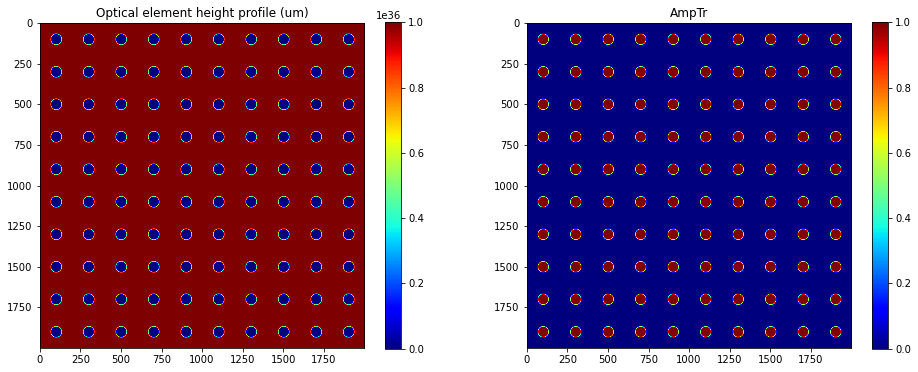

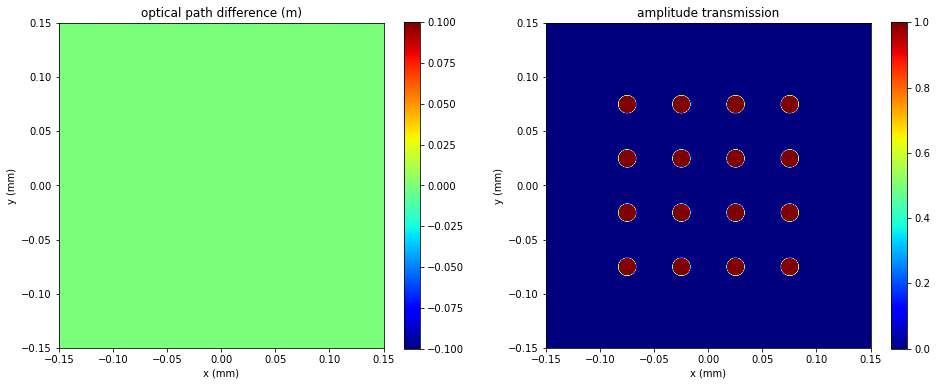

In [192]:
%autoreload 2
from Optics import *

''' sampling parameters '''
E = ekev*1000
OE_width = 0.5e-3      # physical size of OE aperture
#OE_width = 50e-6
nx = 2000; ny = nx     # number of points in H and V

# initialize OE container
OE_Apt = SRWLOptA('r','a',OE_width,OE_width)
#OE_Tr = SRWLOptT(nx,ny,OE_width,OE_width,_Fx=f,_Fy=f,_x=0,_y=0,_eStart=E,_eFin=E)  # Fx given if lens
OE_Tr = SRWLOptT(nx,ny,OE_width,OE_width,_x=0,_y=0,_eStart=E,_eFin=E)              # Fx not given if aperture

OE_x = np.linspace(-OE_width/2,OE_width/2,nx)
OE_y = np.linspace(-OE_width/2,OE_width/2,ny)
OE_x, OE_y = np.meshgrid(OE_x,OE_y)

# sub structures per pixel
nlx = int(OE_width/(50e-6)); nly = nlx   # numeber of lens in each dimension over the full axis
if nlx != OE_width/50e-6:
    print('need integer number of micro lens')

''' OE variables '''
n = 1 - 5.89e-6           # material refractive index
d_abs = 788e-6        # material absorption depth
#n = 1-1e-5
#d_abs = 100e-6
f_lens = 0.5          # lens focal distance (m)
f_prism = 0.3         # prism focal distance (m)
r_hole = 50e-6/6      # pinhole aperture radius (m)
d_hole = 200/3 * 1e-6 # prism opening size
roix = 4; roiy = 4    # number of lens in each dimension that is installed

OE_type = 'Pinhole Array'


if OE_type == 'Lens':
    f = f_lens; z2 = f
    OE_z = Perfect_lens(OE_x,OE_y,n,f)
if OE_type == 'Lens Array':
    f = f_lens; z2 = f
    OE_z = Perfect_lens_array(OE_x,OE_y,n,f,nlx,nly)
    
if OE_type == 'Pinhole':
    r_hole = r_hole; z2 = 0.02
    OE_z = Pinhole(OE_x,OE_y,r_hole)
if OE_type == 'Pinhole Array':
    r_hole = r_hole; z2 = 0.02
    OE_z = Pinhole_array(OE_x,OE_y,r_hole,nlx,nly)
    
if OE_type == 'Prism':
    f = f_prism; z2 = f
    OE_z = Prism(OE_x,OE_y,n,f,d_hole)
if OE_type == 'Prism Array':
    f = f_prism; z2 = f
    OE_z = Prism_array(OE_x,OE_y,n,f,d_hole,nlx,nly)
    
if OE_type == 'Double Slit':
    slit_width = 10e-6; slit_sep = 100e-6; z2 = 5
    OE_z = Double_slit(OE_x,OE_y,10e-6,100e-6)
    

Calc_OPD_and_AmpTr(OE_Tr, OE_z, n,d_abs,nlx,nly,roix,roiy)

# plot OE
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(OE_z*1e6,cmap='jet')
plt.colorbar()
plt.title('Optical element height profile (um)')

plt.subplot(1,2,2)
plt.imshow(np.exp(-OE_z/d_abs),cmap='jet')
plt.colorbar()
plt.title('AmpTr')

OPD_show = np.array(OE_Tr.arTr)[1::2].reshape(ny,nx)
AmpTr_show = np.array(OE_Tr.arTr)[0::2].reshape(ny,nx)

# plot transmission and OPD
xlimi = -OE_width/2*0.6; xlimf = OE_width/2*0.6
ylimi = -OE_width/2*0.6; ylimf = OE_width/2*0.6


plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(
    OPD_show[int(nx*0.2):int(nx*0.8),int(ny*0.2):int(ny*0.8)],cmap='jet',
    extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.title('optical path difference (m)')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(
    AmpTr_show[int(nx*0.2):int(nx*0.8),int(ny*0.2):int(ny*0.8)],cmap='jet',
    extent = [xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
#plt.imshow(AmpTr_show,cmap='jet')
plt.colorbar()
plt.title('amplitude transmission')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

plt.savefig(OE_type+'_OPD_AmpTr.png',transparent=True)

In [193]:
# calculate the center single square diffraction, f should be much smaller than Fresnel distance ~1m.

# compare lens array and aperture array
# tell Mike what I learnt about SRW/ XRT and their difficulties
# show what I calculated using the 4x4 pixel arrays
    # calculate intensity loss due to absorption
    # calculate intensity within no charge sharing boundary (see Yanwen's paper)

### Propagation

*****Defining optical beamline(s) ...
*****Collimating CRL and ideal mirror
*****setting-up optical elements, beamline:bl0
save hdf5:WPG_output\g6_742kev_bl0.h5
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0005
	Dy = 0.0005
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 8000000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 6742.0
		eStart = 6742.0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 2000
		ny = 2000
		xFin = 0.00025
		xStart = -0.00025
		yFin = 0.00025
		yStart = -0.00025
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 0.02
	treat = 0
	

*****reading wavefront from h5 file...
R-space
nx  2000  range_x [-1.0e+00, 1.0e+00] mm
ny  2000  range_y [-1.0

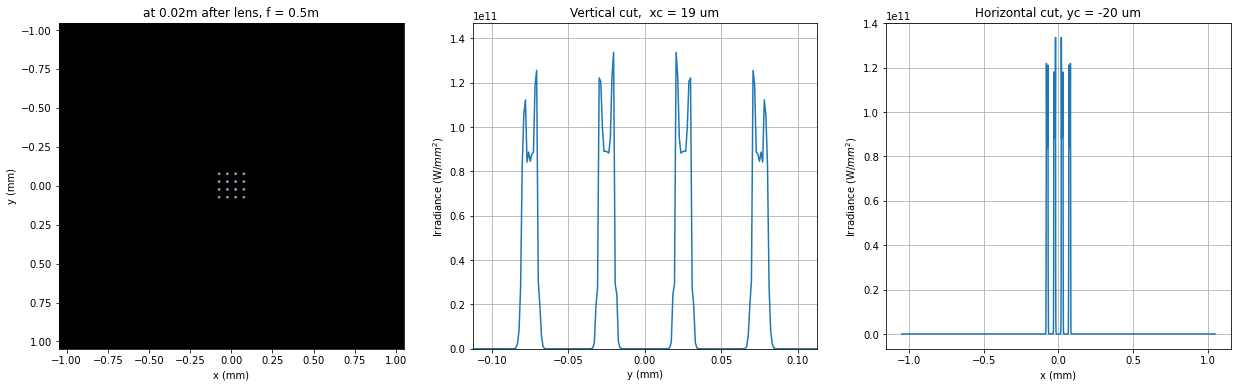

In [194]:
''' Propagation distance '''

''' WPG '''
print('*****Defining optical beamline(s) ...')

optBL0 = Beamline()
#optBL0.append(Aperture(shape='c',ap_or_ob='a',Dx=range_xy), Use_PP())# circular CRL aperture
optBL0.append(OE_Apt,    Use_PP())
optBL0.append(OE_Tr,     Use_PP())
optBL0.append(Drift(z2), Use_PP(semi_analytical_treatment=1))

print('*****Collimating CRL and ideal mirror')
bPlotted = False
isHlog = False
isVlog = False
bSaved = True
optBL = optBL0
strBL = 'bl0'
pos_title = 'at exp hall wall'
print('*****setting-up optical elements, beamline:'+ strBL)

bl = optBL
#print(bl)

if bSaved:
    out_file_name = os.path.join(strDataFolderName, fname0+'_'+strBL+'.h5')
    print('save hdf5:'+ out_file_name)
else:
    out_file_name = None

startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

# plot
print('*****focusing')
plot_wfront(mwf, 'at '+str(z2)+'m after lens, f = {}m'.format(f),False, False, 1e-4,1e-7,'x', True, saveDir='./'+strDataFolderName)
plt.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
plt.axis('tight')
print('FWHMx [mm], theta_fwhm [urad]: {}, {}'.format(calculate_fwhm_x(mwf)*1e3, calculate_fwhm_x(mwf)/(z1+z2)*1e6))
print('FWHMy [mm], theta_fwhm [urad]: {}, {}'.format(calculate_fwhm_y(mwf)*1e3, calculate_fwhm_y(mwf)/(z1+z2)*1e6))

R-space


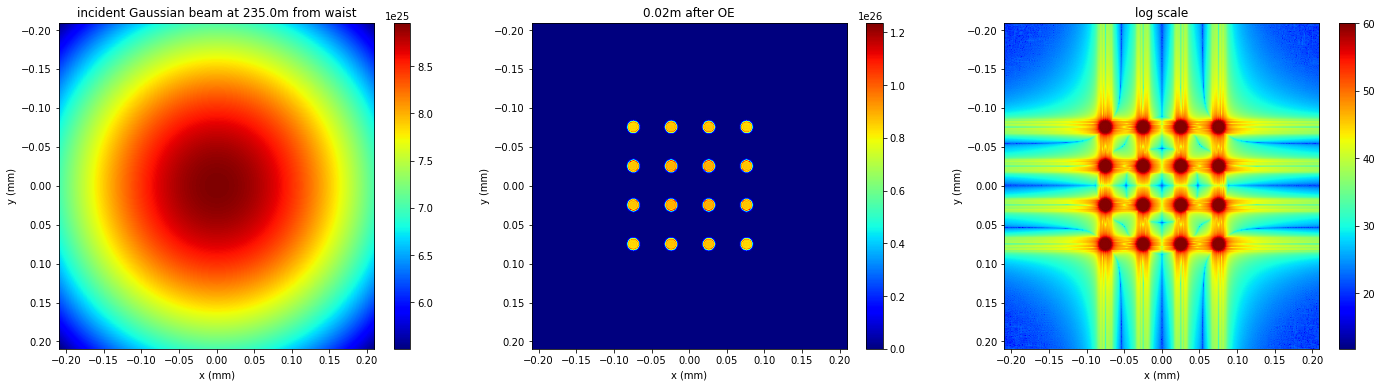

In [195]:
# plot result
[nx, ny, xmin, xmax, ymin, ymax] = get_mesh(mwf)
dx = (xmax-xmin)/(nx-1)
dy = (ymax-ymin)/(ny-1)
[xmin, xmax, ymin, ymax] = mwf.get_limits()

roixi = int(nx*0.4); roixf = int(nx*0.6)
roiyi = int(ny*0.4); roiyf = int(ny*0.6)

xlimi = xmin*0.2; xlimf = xmax*0.2
ylimi = ymin*0.2; ylimf = ymax*0.2

plt.figure(figsize=(24,6))
plt.subplot(1,3,1)
plt.imshow(
    Wavefront(wfr0).get_intensity(slice_number=0)[roixi:roixf,roiyi:roiyf],cmap='jet',
    extent=[xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('incident Gaussian beam at {}m from waist'.format(z1))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

plt.subplot(1,3,2)
plt.imshow(
    mwf.get_intensity(slice_number=0)[roixi:roixf,roiyi:roiyf],cmap='jet',
    extent=[xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('{}m after OE'.format(z2))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

plt.subplot(1,3,3)
plt.imshow(
    np.log(mwf.get_intensity(slice_number=0))[roixi:roixf,roiyi:roiyf],cmap='jet',
    extent=[xlimi*1e3, xlimf*1e3, ylimi*1e3, ylimf*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('log scale')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

plt.savefig(OE_type+'_intensity.png',transparent=True)

In [196]:
# info
print('propagation distance {}m'.format(z2))
print('focal distance {}m'.format(f))
#diffraction limit
wavelength = 3e8/((ekev*1e3/6.582119569e-16)/np.pi/2)
dlim = z2*wavelength/(10e-6)
print('diffraction limit {} um'.format(round(dlim*1e6,4)))

propagation distance 0.02m
focal distance 0.5m
diffraction limit 0.3681 um


0.9955300083262333


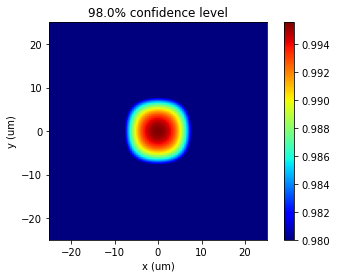

In [197]:
''' Confidence Level '''
from scipy.special import erf

x0 = np.linspace(-0.5,0.5,100)
y0 = np.linspace(-0.5,0.5,100)
xx,yy = np.meshgrid(x0,y0)
zz = np.zeros(xx.shape)

S = 0.385
clim = 0.98

def PC(S,x0,y0):
    w0 = S * np.sqrt(2/np.log(2))/2
    A = 0.5 * np.sqrt(np.pi/2) * w0 * (erf(np.sqrt(2)*(x0+0.5)/w0) - erf(np.sqrt(2)*(x0-0.5)/w0))
    B = 0.5 * np.sqrt(np.pi/2) * w0 * (erf(np.sqrt(2)*(y0+0.5)/w0) - erf(np.sqrt(2)*(y0-0.5)/w0))
    C = np.pi/2 * w0**2
    return A*B/C

def Confident(S,clim,x0,y0):
    confidence = PC(S,x0,y0)
    return confidence >= clim

# populate sample pixel
for i,x in enumerate(x0):
    for j,y in enumerate(y0):
        zz[i,j] = PC(S,x,y)
plt.figure()
plt.imshow(
    zz,cmap='jet',clim=clim,
    extent = [-25,25,-25,25])
plt.colorbar()
plt.title('{}% confidence level'.format(clim*100))
plt.xlabel('x (um)')
plt.ylabel('y (um)')
print(zz.max())

R-space
roi 190x190
84.0% intensity within 98.0% confidence


Text(0.5, 1.0, '98.0% mask')

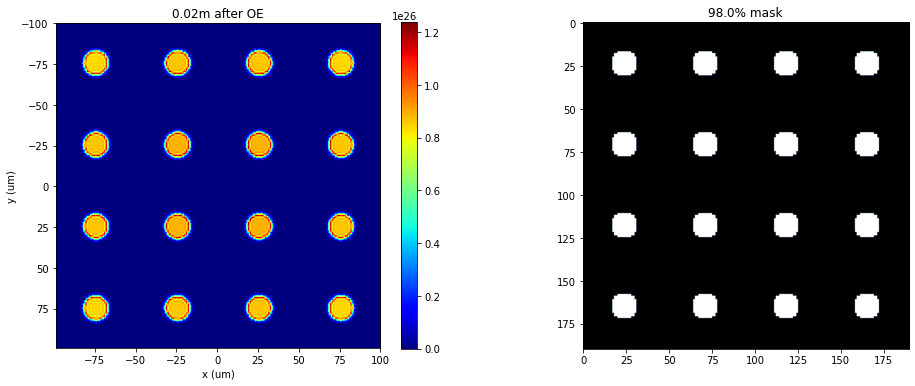

In [198]:
# check how much intensity is confident
def Confidence_mask(I,S,clim,nlx,nly):
    nx, ny = I.shape
    mask = np.zeros((nx,ny))
    npts = int(nx/nlx)
    for il in range(nlx):
        xi = il * npts
        for jl in range(nly):
            yi = jl * npts
            for i in range(npts):
                for j in range(npts):
                    x0 = (i-npts/2)/npts
                    y0 = (j-npts/2)/npts
                    if Confident(S,clim,x0,y0):
                        mask[xi+i,yi+j] = 1

    return mask

# crop out roi
[xmin, xmax, ymin, ymax] = mwf.get_limits()
wave_x = np.linspace(xmin, xmax, npoints)
wave_y = np.linspace(ymin, ymax, npoints)
nnx = (wave_x > roix/2 * 50e-6).sum()
nny = (wave_y > roiy/2 * 50e-6).sum()
print('roi {}x{}'.format(npoints-nnx*2,npoints-nny*2))

Idet = mwf.get_intensity(slice_number=0)[nnx:-nnx,nny:-nny]
clim = 0.98

mask = Confidence_mask(Idet,S,clim,roix,roiy)

confidence = (Idet*mask).sum() / Idet.sum()
print('{}% intensity within {}% confidence'.format(round(confidence*100,1), clim*100))

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(
    Idet,cmap='jet',
    extent = [wave_x[nnx]*1e6, wave_x[-nnx]*1e6, wave_y[nny]*1e6, wave_y[-nny]*1e6])
plt.colorbar()
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.title('{}m after OE'.format(z2))
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title('{}% mask'.format(clim*100))

